# Filipino Family Income and Expenditures

The approach is as follows:
1. Clean the data
2. Categorize the data
3. Perform univariate analysis for each feature in each category
4. Perform bivariate/multivariate analysis using features in the same category
6. Analyze the relation between features in the category and the total household income
7. Build a model that can predict the total household income

Note: This notebook uses ipywidgets to create interactive plots. If you are viewing this notebook on GitHub, the interactive plots will not be displayed. To view the interactive plots, please clone the repository and run it locally.

## 1. Import Python packages

In [1]:
import pandas as pd
import numpy as np

## 2. Loading and Categorizing the Dataset

In [2]:
data = pd.read_csv('data/Family Income and Expenditure.csv')

### 2.1 Cleaning region names

For visualization purposes, the regions will be represented by their numbers. The space in " ARMM" will be removed resulting to "ARMM".

In [3]:
from utils.data_utils import clean_region_names
data = clean_region_names(data)
print(data['Region'].unique())

['CAR' 'XIII' 'VI' 'V' 'ARMM' 'III' 'II' 'IV-A' 'VII' 'X' 'XI' 'VIII' 'I'
 'NCR' 'IV-B' 'XII' 'IX']


### 2.2 Correcting misspelled columns

In [4]:
data.rename(columns={"Total Income from Entrepreneurial Acitivites": "Total Income from Entrepreneurial Activities"}, inplace=True)

### 2.4 Handling missing values
Only the columns 'Household Head Occupation', 'Household Head Class of Worker', and 'Toilet Facilities' have missing values. 'Household Head Occupation' and 'Household Head Class of Worker' have the same number of nan values, and so it will be assumed that nan correponds to which are unemployed ('Unemployed'). Meanwhile, nan values in 'Toilet Facilities' will be assumed to correspond to not having toilet facilities ('None').

In [5]:
from utils.data_utils import handle_missing_values
data = handle_missing_values(data)

Columns with Missing Values:
Household Head Occupation         7536
Household Head Class of Worker    7536
Toilet Facilities                 1580
dtype: int64


### 2.5 Removing outliers

Since the main goal is to build a model that can predict the total household income, the outliers of this column will be removed based on the z-scores. Although these outliers are likely genuine observations, model robustness will be prioritized over accuracy in this approach.

<Axes: >

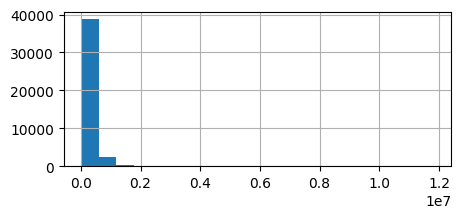

In [6]:
data['Total Household Income'].hist(bins=20, figsize=(5, 2))

In [7]:
from utils.data_utils import remove_income_outlier
data = remove_income_outlier(data)

### 2.6 Categorizing the data based on domain knowledge
The data was sorted into distinct categories, namely expenditures, income, household head, appliances, property, and family. The rationale behind this categorization is to streamline our data analysis process and gain a deeper understanding of various aspects of the dataset.

In [8]:
from utils.data_utils import get_expenditures_data, get_income_data, get_householdhead_data, get_appliances_data, get_property_information, get_family_composition

expenditures_data = get_expenditures_data(data)
income_data = get_income_data(data)
householdhead_data = get_householdhead_data(data)
appliances_data = get_appliances_data(data)
property_data = get_property_information(data)
family_composition_data = get_family_composition(data)

# Checking if all of the columns have been categorized 
collection = expenditures_data +  income_data + appliances_data +  householdhead_data + family_composition_data +  property_data
missing = [element for element in data.columns if element not in collection]
print(missing)


['Region']


The only data column missing from the collection is 'Region', which does not need to be categorized. Thus, we know that all of the columns have been categorized.

### 2.4 Categorizing the data based on data type
The data was also sorted based on data type which will be useful when transforming them into features for the machine learning model.

In [9]:
from utils.data_utils import categorize_by_datatype
categorical_data, continuous_data, binary_data, counting_data = categorize_by_datatype(data)

## 3. Exploring the Total Household Income

In this section, we seek to answer the folowing questions:

1. What is the average total household income in the Philippines? How about in each region?
2. What regions have the highest/lowest average household income?
3. What are the regions with an average household income below the national average?
4. Which among the regions have the highest wealth inequality?
5. What is the main source of income of most households in the Philippines? How about in each region?
6. Which main source of income gives the highest average household income in the Philippines and in each region?
7. How much does the average Filipino household earn from entrepreneurial activities? Does this vary across regions?

### 3.1 Total Household Income

We can answer questions 1-4 using the 'Total Household Income' and 'Regions' columns.

In [10]:
from utils.histogram_utils import plot_histogram
from utils.bar_utils import bar_chart_regional_average, stacked_bar
from ipywidgets import interact, fixed

#### 3.1.1. Distribution of total household income in the Philippines and in each region

In [11]:
regions = data['Region'].unique()
regions = np.append(regions, 'Philippines')
interact(plot_histogram, data=fixed(data), key=fixed('Total Household Income'), figsize=fixed((10, 5)), region=regions)

interactive(children=(Dropdown(description='region', options=('CAR', 'XIII', 'VI', 'V', 'ARMM', 'III', 'II', '…

<function utils.histogram_utils.plot_histogram(data, key, region='Philipines', show_outliers=False, figsize=(5, 3))>

The median annual household income in the Philippines is P161,843.50 or P13,486.96 per month. Notably, the distribution is heavily skewed to the right. In this case, it will be better to use the median to determine the average.

#### 3.1.2. Side-by-side comparison of average household income in each region

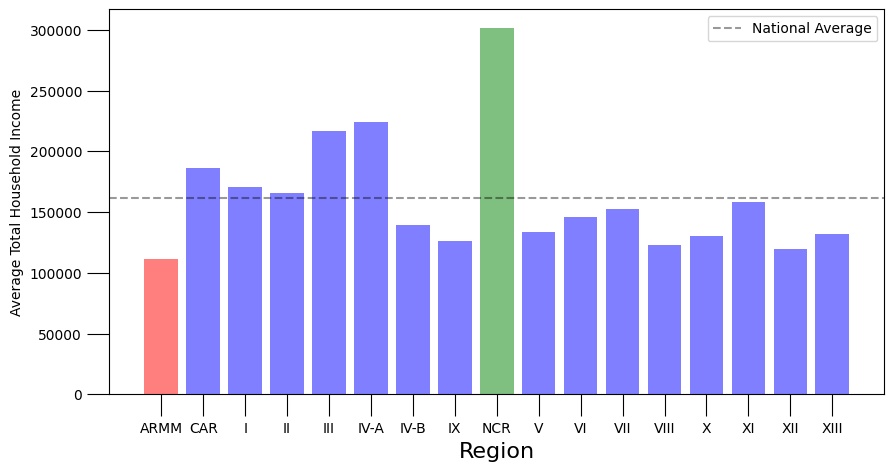

In [12]:
bar_chart_regional_average(data, 'Total Household Income')

* Among the regions, NCR had the highest average total household income. This is expected due to the region's status as the country's economic and political center, leading to the availability of more lucrative jobs.
* Meanwhile, ARMM had the the lowest average total household income which may be due to the political instability in the region.
* Only ARMM falls below the national average income. 

#### 3.1.2 Visualizing average household income across the regions using a choropleth map

Since the data can be grouped by region, it would be interesting to visualize it with a choropleth map.

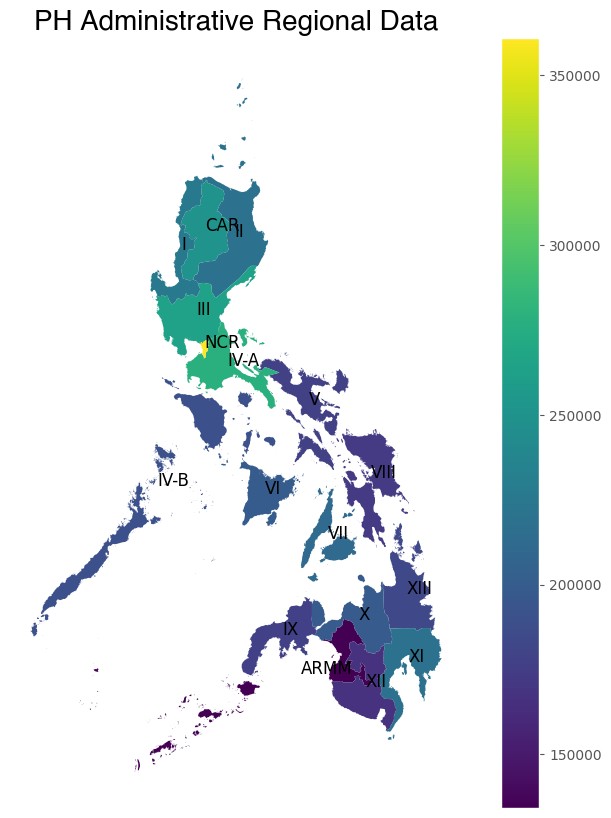

In [13]:
from utils.choropleth_utils import load_regions_geodataframe, choropleth, get_regional_averages
regions_gdf_clean = load_regions_geodataframe()
regional_averages = get_regional_averages(data, ['Total Household Income'])
merged_df = pd.merge(regions_gdf_clean, regional_averages, left_on='REGION', right_on='Region', how='left')
choropleth(merged_df, 'Total Household Income')

The National Capital Region (NCR) had the brightest color for the total household income. There is a gradual spread of brightness from NCR which implies that NCR's economic prosperity influences its neighboring regions to some extent. The economic activity and opportunities in the capital appear to have a ripple effect, albeit diminishing, on the adjacent areas.

This map also showcases the geographical features of the capital city of Manila, i.e. the natural harbor. This natural harbor has historically played a crucial role in the economic development of the National Capital Region. The presence of a well-positioned natural harbor in Manila has facilitated trade and commerce, making it a hub for maritime activities. This advantage has attracted businesses, industries, and investments to the region over time.

The distance from NCR could be an interesting feature to include in model development, though I will leave this task for a different time.

### 3.2 Main Sources of Income

#### 3.2.1 Main sources of Income in the Philippines

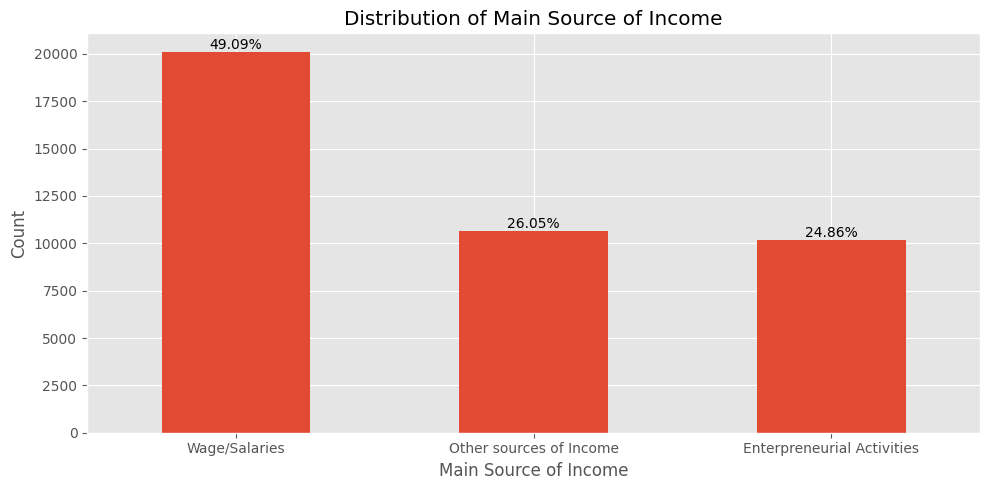

In [14]:
import matplotlib.pyplot as plt

# Create the bar chart
counts = data['Main Source of Income'].value_counts()
plt.figure(figsize=(10, 5))
ax = counts.plot(kind='bar', rot=0)

# Add percentages on top of the bars
total = len(data)
for i, v in enumerate(counts):
    percentage = (v / total) * 100
    ax.text(i, v, f'{percentage:.2f}%', ha='center', va='bottom')

# Show the plot
plt.xlabel('Main Source of Income')
plt.ylabel('Count')
plt.title('Distribution of Main Source of Income')
plt.tight_layout()
plt.show()


The most common main source of income in the Philippines is wage/salaries at 49.09%, followed by other sources of income (26.05%), and entrepreneurial activitites (24.86%).

#### 3.2.2 Main Sources of Income per Region

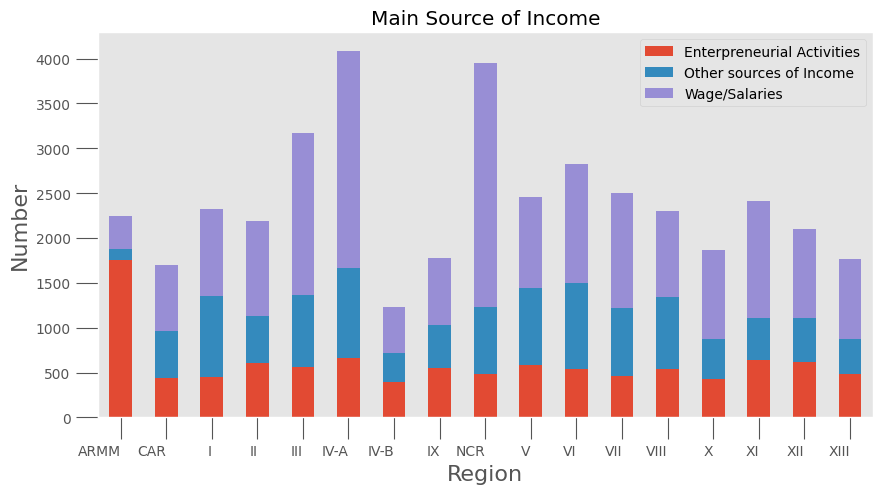

In [15]:
stacked_bar(data, 'Main Source of Income')

Among the regions, ARMM notably had the highest number of household who relies on entrepreneurial activities.

#### 3.2.2 Average Income per Source of Income

<Axes: xlabel='Main Source of Income'>

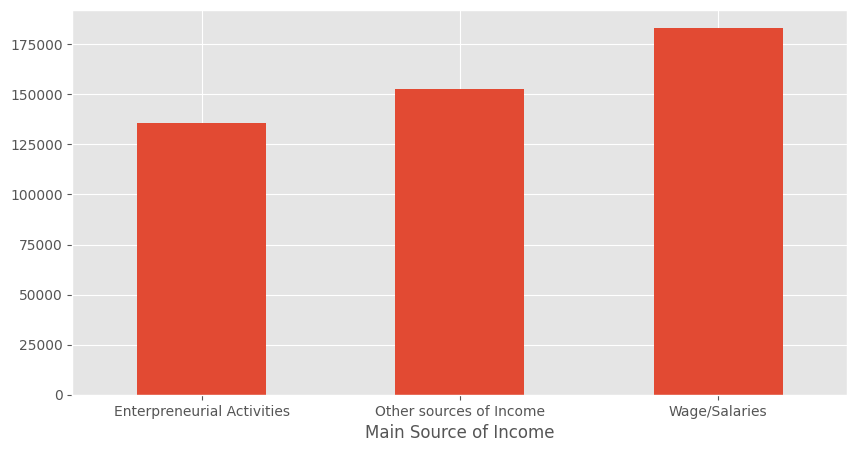

In [16]:
data.groupby(['Main Source of Income'])['Total Household Income'].median().plot(kind='bar', figsize=(10, 5), rot=0)

<Axes: xlabel='Main Source of Income'>

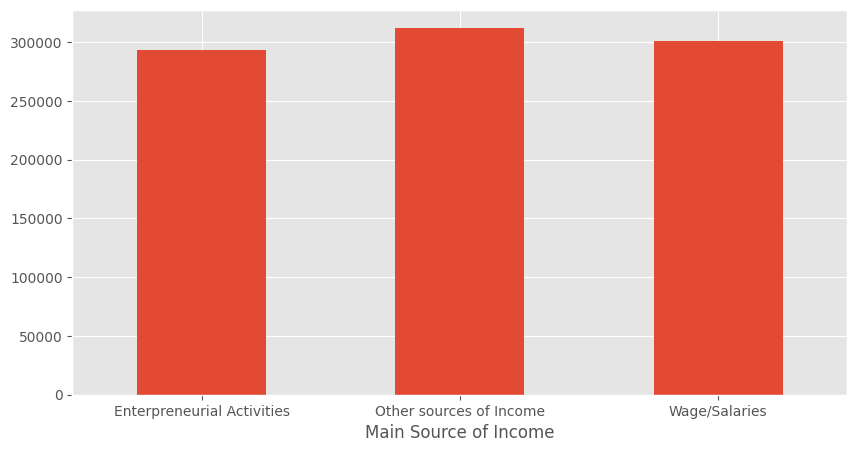

In [17]:
data[data['Region'] == 'NCR'].groupby(['Main Source of Income'])['Total Household Income'].median().plot(kind='bar', figsize=(10, 5), rot=0)

### 3.3 Total Household Income from Entrepreneural Activities

#### 3.3.1. Distribution of income from entrepreneurial activities in the Philippines and per region

In [18]:
interact(plot_histogram, data=fixed(data), key=fixed('Total Income from Entrepreneurial Activities'), figsize=fixed((10, 5)), region=regions)

interactive(children=(Dropdown(description='region', options=('CAR', 'XIII', 'VI', 'V', 'ARMM', 'III', 'II', '…

<function utils.histogram_utils.plot_histogram(data, key, region='Philipines', show_outliers=False, figsize=(5, 3))>

#### 3.3.2. Side-by-side comparison of average household income from entrepreneurial activities in each region

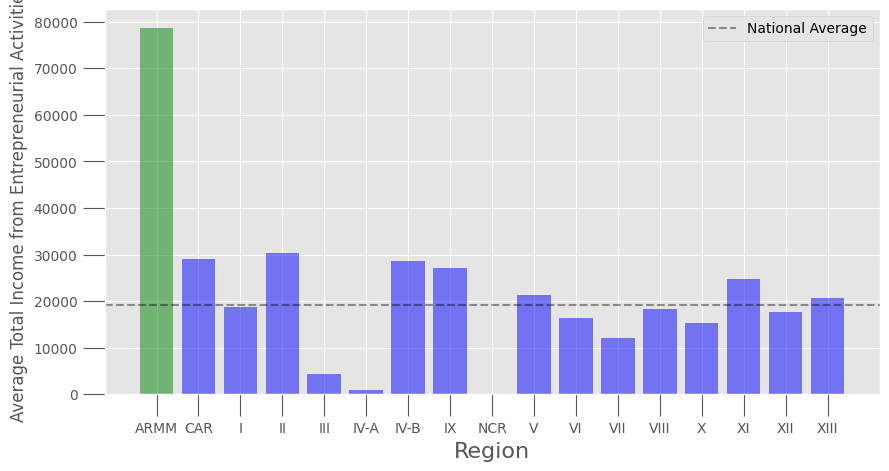

In [19]:
bar_chart_regional_average(data, 'Total Income from Entrepreneurial Activities')

ARMM relied mostly on entrepreneurial activites as their main source of income. The ARMM region, situated in the southern part of the Philippines, had encountered challenges such as underdeveloped infrastructure, limited access to quality education, and a history of conflict. These factors made it more difficult for traditional industries to thrive and led to a higher reliance on entrepreneurial endeavors.

### 3.4 Relating Total Household Income and Income from Entrepreneurial Activities

In [20]:
from utils.scatter_utils import basic_scatter_plot, regional_scatter_plot

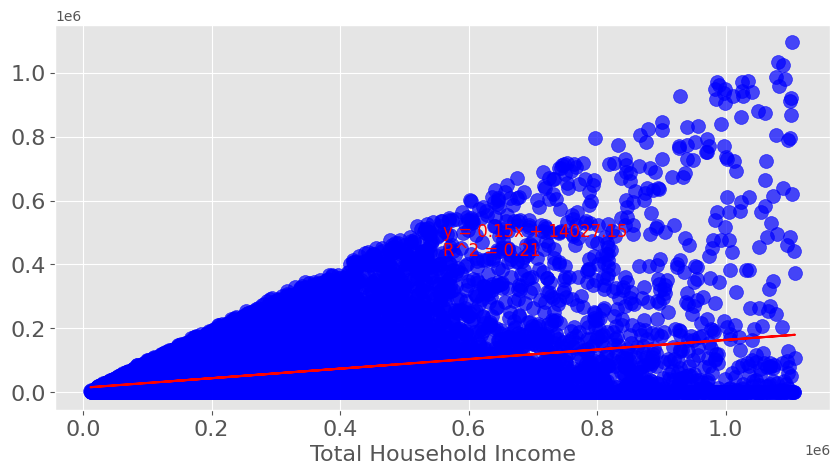

In [21]:
basic_scatter_plot(data['Total Household Income'], data['Total Income from Entrepreneurial Activities'])

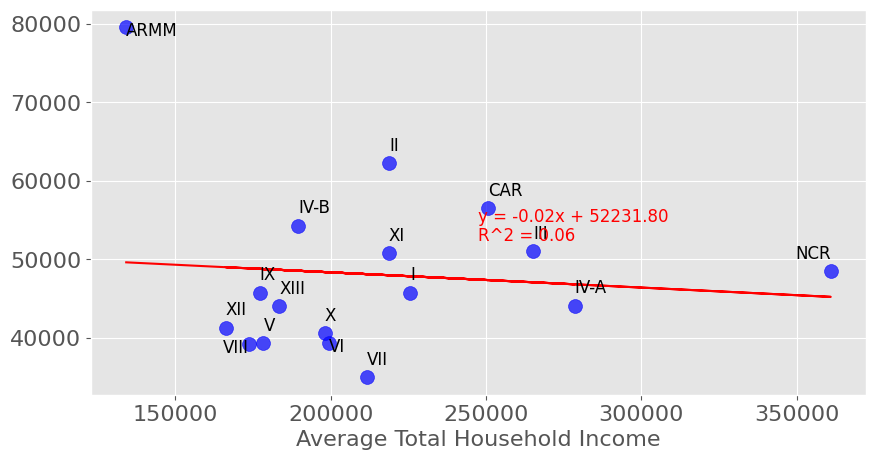

In [22]:
regional_scatter_plot(data, 'Total Income from Entrepreneurial Activities')

There is very weak correlation between the total household income and income from entrepreneurial activities.

### 3.4 Deeper Exploration

#### 3.4.1 Number of people below the poverty threshold

The poverty threshold in the Philippines in 2015 is a monthly income of P9,064 according to [PSA](https://rsso11.psa.gov.ph/sites/default/files/attachments/Special%20Release%20Poverty%202015.pdf). This is the income needed to meet their most basic food and non-food needs.

In [23]:
def bar_plot_below_poverty_line(data, key):
    below_poverty_line = data[data['Total Household Income'] < 9064*12]
    (below_poverty_line.value_counts(key) / data[key].value_counts()).plot(kind='bar', figsize=(10, 5), rot=0)
    plt.title('Percentage of Households Below Poverty Line by ' + key)

In [24]:
interact(bar_plot_below_poverty_line, data=fixed(data), key=binary_data)

interactive(children=(Dropdown(description='key', options=('Electricity',), value='Electricity'), Output()), _…

<function __main__.bar_plot_below_poverty_line(data, key)>

In [25]:
interact(bar_plot_below_poverty_line, data=fixed(data), key=counting_data)

interactive(children=(Dropdown(description='key', options=('Agricultural Household indicator', 'Members with a…

<function __main__.bar_plot_below_poverty_line(data, key)>

## 4. Exploring Household Expenditures and its Relation to Household Income

### 4.1 Household Expenditures

We seek to answer the following questions:

* How do households allocate their budget among different expenditure categories?
* How much of household expenditures are allocated to essential needs (e.g., housing, food, healthcare) versus discretionary spending (e.g., entertainment, travel)?

#### 4.1.1 Side-by-side comparison of household expenditures

<BarContainer object of 17 artists>

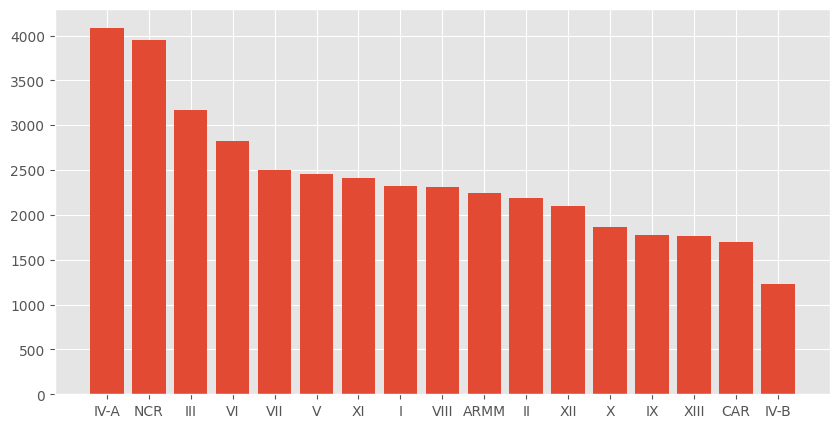

In [26]:
plt.figure(figsize=(10, 5))
plt.bar(data['Region'].value_counts().index, data['Region'].value_counts())

In [27]:
from utils.regional_utils import create_dataframe_min_max

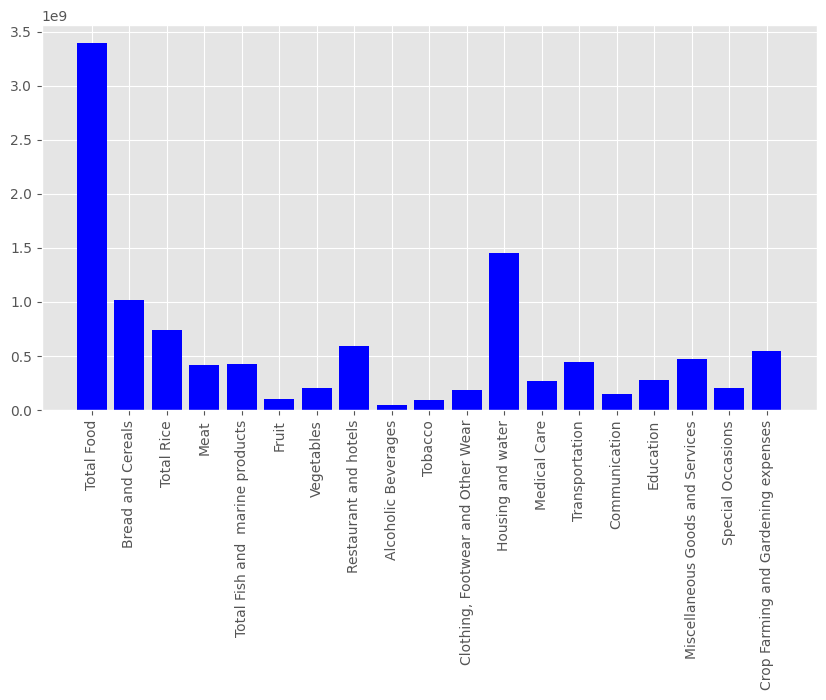

In [28]:
shortened_expenditures_data = [col.replace(' Expenditure', '') for col in expenditures_data]
plt.figure(figsize=(10, 5))
plt.bar(shortened_expenditures_data, data[expenditures_data].sum().values, color='blue')
plt.xticks(rotation=90)
plt.show()

### 4.1.2. Regional Expenditures

* Do households in certain regions spend more on specific categories?

In [29]:
interact(bar_chart_regional_average, data=fixed(data), key=expenditures_data, average=True)

interactive(children=(Dropdown(description='key', options=('Total Food Expenditure', 'Bread and Cereals Expend…

<function utils.bar_utils.bar_chart_regional_average(data, key: str)>

In [30]:
# Summary of regional average icome and expenditures, showing the region with the highest (0) and lowest (1) average income and expenditures.
max_min_dataframe = create_dataframe_min_max(data, expenditures_data)
max_min_dataframe

,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,NCR,XIII,VIII,NCR,VI,NCR,CAR,NCR,II,III,NCR,NCR,NCR,NCR,NCR,CAR,NCR,III,ARMM
1,X,II,VII,ARMM,X,X,X,VIII,ARMM,CAR,ARMM,IX,ARMM,ARMM,IX,I,ARMM,ARMM,I


NCR has the highest average food expenditures. The region also has the highest expenditures in meat, fruits, restaurant and hotels, clothing, housing and water, transportation, communication, education, and miscellaneous goods and services. Meanwhile, it had the lowest expenditures for crop farming and gardening.

* As the country's economic and political center, there are more lucrative job opportunities not available in other regions. The availability of opportunities brings more people to the region, resulting in higher demand for housing, consequently raising the costs.
* Similar to housing, other basic necessities such as food are more expensive in the region due to the increased demand. This may also be explained by more expensive food preferences of the residents, i.e. having higher meat and fruits expenditures, which tend to be more expensive than food staples such as bread, cereals, and rice.
* Having the highest expenditures on restaurants and hotels and miscellaneous goods and services may be explained by the availability of such establishments in the region (being highly urbanized) and the expectantly higher disposable income of the residents from having higher income. Furthermore, the urban lifestyle (which gets really busy) may also result in more frequent dining out.
* Communication expenditures may be explained by the increased demand for connectivity, i.e. work, school, socialization, and the availability of high-end services, such as faster and more expensive internet plans.
* Clothing expenditures may be explained by the urban lifestyle, e.g. keeping up with the trends from social media, occupations that require more "professional" attire.
* Transportation expenditures in NCR could be explained by long commutes to work/school using various transportation modes such as buses, trains, jeepneys, and taxis. Although NCR is considered highly urbanized, work and school can be in a city different from one's residence. For instance, Malabon is a city in NCR also considered as highly urbanized, with a lot of job opportunities, but some residents still have a preference for jobs/universities in QC, Manila, Makati, etc., because the jobs are usually blue collar, contractual, or "arawan", while schools are limited to community colleges.
* The region has the lowest expenditures in crop farming and gardening, which is expected from being highly urbanized with limited space for agriculture.


Meanwhile, CALABARZON has the highest medical care and special occasions expenditures, CAR for bread and cereals, Eastern Visayas for rice, ARMM for fish and marine and crop farming and gardening, Cagayan Valley for alcoholic beverages, and Central Luzon for tobacco.

### 4.2. Exploring the relation between Household Income and Expenditures

We seek to answer the following questions:

* Is there a correlation between household income and expenditures?
* Are certain types of expenditures more sensitive to changes in income than others?
* What are the major categories of expenditures for households across different income levels?
* Are there regional differences in expenditure patterns and income?
* How much of household expenditures are allocated to essential needs (e.g., housing, food, healthcare) versus discretionary spending (e.g., entertainment, travel)? Do these proportions change with income?

In [31]:
from utils.scatter_utils import regional_scatter_plot
interact(regional_scatter_plot, data=fixed(data), key=expenditures_data)

interactive(children=(Dropdown(description='key', options=('Total Food Expenditure', 'Bread and Cereals Expend…

<function utils.scatter_utils.regional_scatter_plot(data, key)>

In [32]:
from utils.regional_utils import create_dataframe_r_squared
create_dataframe_r_squared(data, expenditures_data)

,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,Tobacco Expenditure,"Clothing, Footwear and Other Wear Expenditure",Housing and water Expenditure,Medical Care Expenditure,Transportation Expenditure,Communication Expenditure,Education Expenditure,Miscellaneous Goods and Services Expenditure,Special Occasions Expenditure,Crop Farming and Gardening expenses
0,0.931552,0.080191,0.223409,0.871481,0.040792,0.392655,0.260251,0.914261,0.161916,0.032235,0.874406,0.966892,0.872877,0.912949,0.957040,0.019133,0.941209,0.301395,0.132952
1,0.965169,0.283179,0.472661,0.933531,0.201971,0.626622,0.510148,0.956170,0.402387,0.179540,0.935097,0.983307,0.934279,0.955484,0.978284,0.138321,0.970159,0.548994,0.364626


The five expenditures that show the strongest connection (correlation) with household income are: Communication Expenditure, Miscellaneous Goods and Services Expenditure, Housing and Water Expenditure, Transportation Expenditure, and Total Food Expenditure. This means that these are the expenses that tend to move together with changes in household income and will be important features when creating a predictive model later on. These correlations are congruent to the data describing which regions have the highest expenditure for each category, i.e. NCR having the highest income also has the highest expenditures in the top 5 strongly-correlated expenditures.

## 5. Exploring Household Head Data and its Relation to Household Income

In this section, we will analyze the data concering the family household head. We seek to answer the following questions:

* What is the distribution of household head sex in the dataset? Are there more male or female household heads?
* What is the average age of the household heads in the dataset?
* How does the marital status of household heads vary in the dataset? What is the most common marital status?
* What is the most common level of education completed by household heads?
* How many household heads are employed in jobs or businesses? What is the ratio of employed to unemployed household heads?
* What are the most common occupations among household heads?
* How does the class of worker (e.g., self-employed, wage worker, unpaid family worker) vary among household heads?

### 5.1 Household Head Sex Distribution

In [33]:
import seaborn as sns

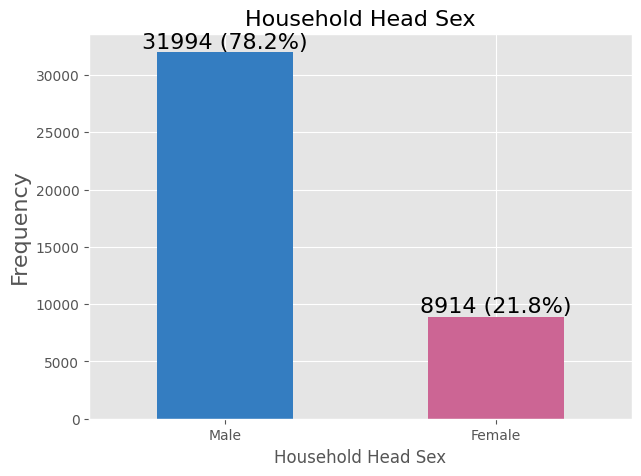

In [34]:
custom_palette = {'Male': '#347DC1', 'Female': '#CC6594'}
# Number of male vs female household head
gender_counts = data['Household Head Sex'].value_counts()
total_households = len(data)

# Calculate the percentages
male_percentage = (gender_counts['Male'] / total_households) * 100
female_percentage = (gender_counts['Female'] / total_households) * 100

# Plot the bar chart with percentage comparison
plt.figure(figsize=(7, 5))
ax = gender_counts.plot(kind='bar', color=['#347DC1', '#CC6594'], rot=0)

# Display the percentages on the plot
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height() / total_households * 100:.1f}%)',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.ylabel('Frequency', fontsize=16)
plt.title('Household Head Sex', fontsize=16)
plt.show()


#### Female-Male Ratio vs. Total Household Income

Based on the data, 78.2% of the household heads are males, while 21.8% are females. The data indicates a significant gender disparity among household heads, with males being predominant in this role. The higher representation of males as household heads may suggest prevailing cultural or societal norms, i.e., traditional gender roles within the context of household leadership.

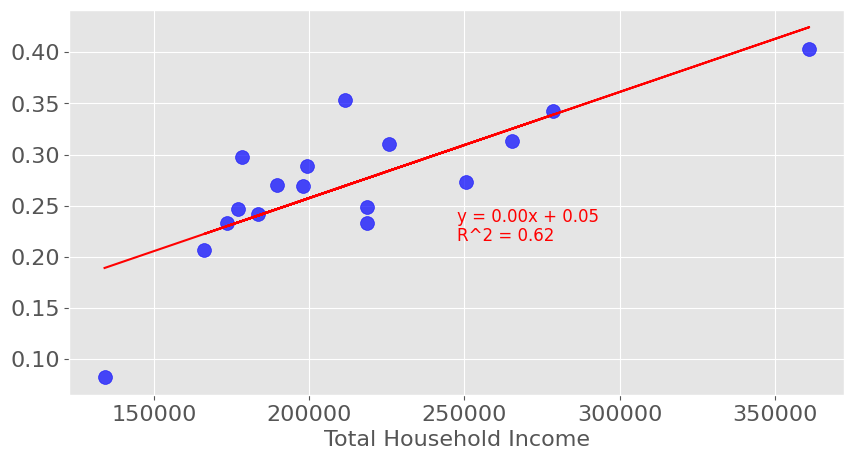

In [35]:
from utils.scatter_utils import basic_scatter_plot
ratio_df = data.groupby("Region")["Household Head Sex"].value_counts(normalize=True).unstack()
ratio_df["Female to Male Ratio"] = ratio_df["Female"] / ratio_df["Male"]
basic_scatter_plot(data.groupby("Region")["Total Household Income"].mean(), ratio_df["Female to Male Ratio"])

There is a high correlation between the female-to-male household ratio and the total household income across the regions.

### 5.2 Household Head Marital Status

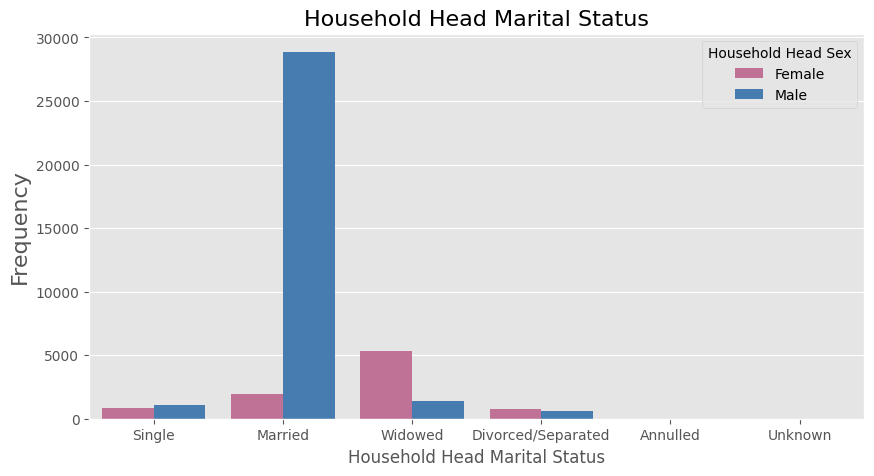

In [36]:
plt.figure(figsize=(10,5))
s = sns.countplot(x='Household Head Marital Status', hue='Household Head Sex', data=data, palette=custom_palette)
s.set_xticklabels(s.get_xticklabels())
plt.ylabel('Frequency', fontsize=16)
plt.title('Household Head Marital Status', fontsize=16)
plt.show()

* The highest proportion of household heads falls under the category of "male-married." This finding suggests that the majority of households are headed by married men. This aligns with the traditional family structure where men often take on the role of the household head and primary decision-maker.
* The prevalence of male-married household heads could indicate the presence of nuclear families or extended families where the male spouse assumes the leadership position. Further investigation into the age groups and educational backgrounds of male-married household heads might reveal interesting patterns about family dynamics and socio-economic factors.
* The second most common category is "female-widowed" household heads. This finding is significant as it highlights the vulnerability of widowed women who have assumed the role of household head following the loss of their spouses. These women often face unique challenges, including financial responsibilities and single-handedly managing households.
* The presence of a considerable number of female-widowed household heads might also indicate the need for targeted support and social welfare programs to assist these women in managing their households effectively. Understanding the age distribution and geographical location of these households could aid policymakers in tailoring appropriate interventions to address their specific needs.

### 5.2 Household Head Age

<Figure size 700x500 with 0 Axes>

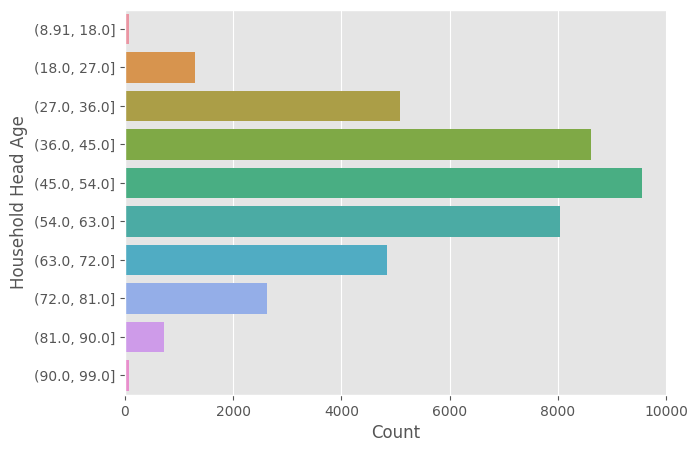

In [37]:
var = 'Household Head Age'
ages = pd.cut(data[var], 10)
plt.figure(figsize=(7,5))
fig, ax = plt.subplots(figsize=(7,5))
s = sns.countplot(y=ages)
s.set(xlabel='Count')
plt.show()

### 5.4 Household Head Education Attainment

This data has a lot of unique values. Thus, we aggregated it using the function aggregate_householdhead_educationi.

In [38]:
from utils.data_utils import aggregate_householdhead_education
data = aggregate_householdhead_education(data)

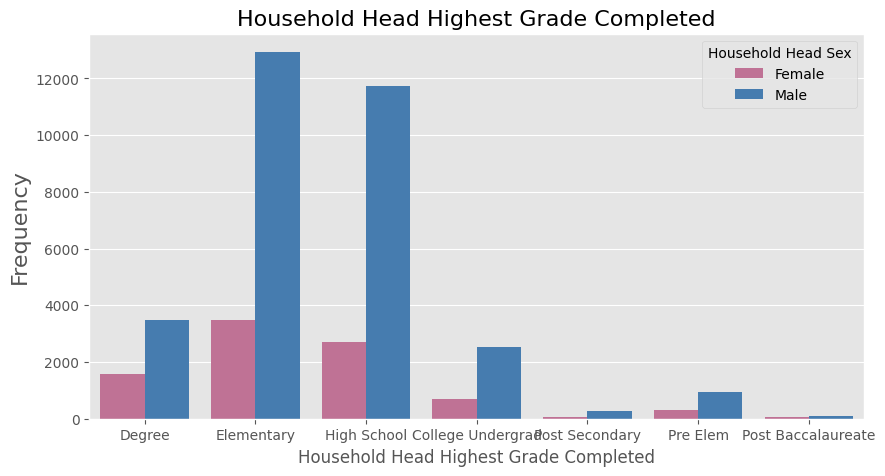

In [39]:
plt.figure(figsize=(10,5))
s = sns.countplot(x='Household Head Highest Grade Completed', hue='Household Head Sex', data=data, palette=custom_palette)
s.set_xticklabels(s.get_xticklabels())
plt.ylabel('Frequency', fontsize=16)
plt.title('Household Head Highest Grade Completed', fontsize=16)
plt.show()